In [2]:
import tensorflow as tf

In [6]:
model = tf.keras.models.load_model("best_functional_model.h5")

In [7]:
model.summary()

Model: "dogs-vs-cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

In [18]:
model.layers[0].input_shape[0]

(None, 150, 150, 3)

In [21]:
model.layers[0].__class__.__name__

'InputLayer'

In [24]:
model.layers[1].input_shape

(None, 150, 150, 3)

In [27]:
import numpy as np
import cv2

# 画像用
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
# モデル読み込み用
from tensorflow.keras.models import load_model
# Grad−CAM計算用
from tensorflow.keras import models
import tensorflow as tf

IMAGE_SIZE  = (150, 150)

def grad_cam(input_model, x, layer_name):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis=0)
    preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # 勾配を計算
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    # 重みを平均化して、レイヤーの出力に乗じる
    weights = np.mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image


In [49]:
model_path = '../models/best_functional_model.h5'
image_path = '../data/dog.1.jpg'

model = load_model(model_path)
x = img_to_array(load_img(image_path, target_size=IMAGE_SIZE))

In [50]:
x

array([[[ 39.,  66.,  96.],
        [ 39.,  65., 100.],
        [ 36.,  61., 102.],
        ...,
        [ 76., 108., 207.],
        [ 89., 123., 220.],
        [ 48.,  85., 174.]],

       [[ 38.,  65.,  95.],
        [ 31.,  57.,  92.],
        [ 36.,  61., 102.],
        ...,
        [ 81., 106., 207.],
        [ 90., 120., 218.],
        [ 50.,  81., 174.]],

       [[ 40.,  67.,  97.],
        [ 37.,  63.,  98.],
        [ 42.,  67., 108.],
        ...,
        [ 84., 106., 207.],
        [ 96., 121., 222.],
        [ 60.,  86., 183.]],

       ...,

       [[182., 188., 200.],
        [189., 195., 209.],
        [189., 195., 209.],
        ...,
        [162., 145., 138.],
        [148., 132., 117.],
        [146., 129., 109.]],

       [[171., 175., 186.],
        [184., 188., 199.],
        [185., 188., 203.],
        ...,
        [ 98., 103.,  83.],
        [ 86.,  88.,  66.],
        [ 96.,  96.,  72.]],

       [[169., 173., 176.],
        [177., 180., 187.],
        [188., 1

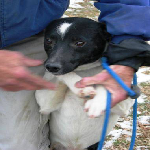

In [29]:
array_to_img(x)

In [40]:
target_layer = 'block4_conv1'
cam = grad_cam(model, x, target_layer)

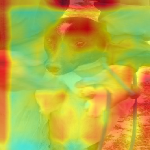

In [41]:
array_to_img(cam)

In [42]:
from PIL import Image 

In [44]:
img = Image.open("../data/dog.1.jpg")

In [48]:
cv2.resize(np.array(img), (150, 150)).shape

(150, 150, 3)